1. Load and Preprocess Images and Annotations

In [ ]:

import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def load_data(data_folder):
    images = []
    labels = []
    for filename in os.listdir(data_folder):
        if filename.endswith(".jpeg"):
            img_path = os.path.join(data_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                preprocessed_img = preprocess_image(img)
                images.append(preprocessed_img)
                annotation_path = os.path.join(data_folder, filename.replace('.jpeg', '.txt'))
                labels.append(load_annotation(annotation_path))
    return images, labels

def preprocess_image(image):
    # Convert image to RGB (since VGG16 expects 3 channels)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_image, (128, 128))
    normalized = resized / 255.0
    return normalized

def load_annotation(file_path):
    with open(file_path, 'r') as file:
        content = file.readline().strip().split()
    label = int(content[0])
    return label

data_folder = r'C:\Users\DELL\Documents\upskills\upskills\Project5_Ag_Crop and weed detection\Project5_Ag_Crop and weed detection\agri_data\data'
images, labels = load_data(data_folder)


2. Create a Dataset

In [11]:
from sklearn.model_selection import train_test_split

X = np.array(images)
y = np.array(labels)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


3. Data Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply the transformations to the training data only
datagen.fit(X_train)


4. Model Architecture and Transfer Learning

In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the VGG16 model, excluding the top fully connected layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add new fully connected layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


5. Train the Model with Data Augmentation

In [14]:
# Train the model with data augmentation
batch_size = 32
epochs = 20

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val))


Epoch 1/20


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.7714 - loss: 0.4733 - val_accuracy: 0.8922 - val_loss: 0.3892
Epoch 2/20
 1/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9062 - loss: 0.4393

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 673ms/step - accuracy: 0.9062 - loss: 0.2380 - val_accuracy: 0.9020 - val_loss: 0.3760
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8724 - loss: 0.3386 - val_accuracy: 0.9020 - val_loss: 0.2877
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 605ms/step - accuracy: 1.0000 - loss: 0.0418 - val_accuracy: 0.9118 - val_loss: 0.2706
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9240 - loss: 0.1912 - val_accuracy: 0.9118 - val_loss: 0.2822
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 703ms/step - accuracy: 0.9062 - loss: 0.1313 - val_accuracy: 0.9216 - val_loss: 0.2835
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.8759 - loss: 0.3085 - val_accuracy: 0.9216 - val_loss: 0.2331
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 754ms/step - accuracy: 0.9688 - loss: 0.1084 - val_accuracy: 0.9314 - val_loss: 0.2373
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9164 - loss: 0.2260 - val_accuracy: 0.9020 - val_loss:

6. Fine-Tuning

In [16]:
# Unfreeze some layers in the base model
import tensorflow as tf
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                         steps_per_epoch=len(X_train) // batch_size,
                         epochs=10,
                         validation_data=(X_val, y_val))


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9374 - loss: 0.1960 - val_accuracy: 0.9314 - val_loss: 0.1622
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 777ms/step - accuracy: 0.8750 - loss: 0.2100 - val_accuracy: 0.9314 - val_loss: 0.1617
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9349 - loss: 0.1562 - val_accuracy: 0.9510 - val_loss: 0.1572
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 639ms/step - accuracy: 0.9688 - loss: 0.0502 - val_accuracy: 0.9510 - val_loss: 0.1559
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9413 - loss: 0.1566 - val_accuracy: 0.9608 - val_loss: 0.1460
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 622ms/step - accuracy: 0.9062 - loss: 0.0913 - val_accuracy: 0.9510 - val_loss: 0.1497
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9617 - loss: 0.1231 - val_accuracy: 0.9412 - val_loss: 0.1473
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 679ms/step - accuracy: 0.9375 - loss: 0.0429 - val_accuracy: 0.9412 

7. Save the Model

In [17]:
# Save the model to a file
model.save('crop_weed_detection_model.h5')


8. Evaluation and Testing

In [19]:
# Evaluate the model on the validation set
from tensorflow.keras.models import Model, load_model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation accuracy: {val_acc}")

# Function to make predictions
def detect_crop_weed(image_path):
    image = cv2.imread(image_path)
    preprocessed_image = preprocess_image(image)
    preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
    prediction = model.predict(preprocessed_image)
    return 'Crop' if prediction[0][0] > 0.5 else 'Weed'

# Load the model from the file
model = load_model('crop_weed_detection_model.h5')

# Test on a new image
test_image_path = os.path.join(data_folder, 'agri_0_456.jpeg')
result = detect_crop_weed(test_image_path)
print(result)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9296 - loss: 0.1624
Validation accuracy: 0.9411764740943909


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Weed


9. Visualize Training History

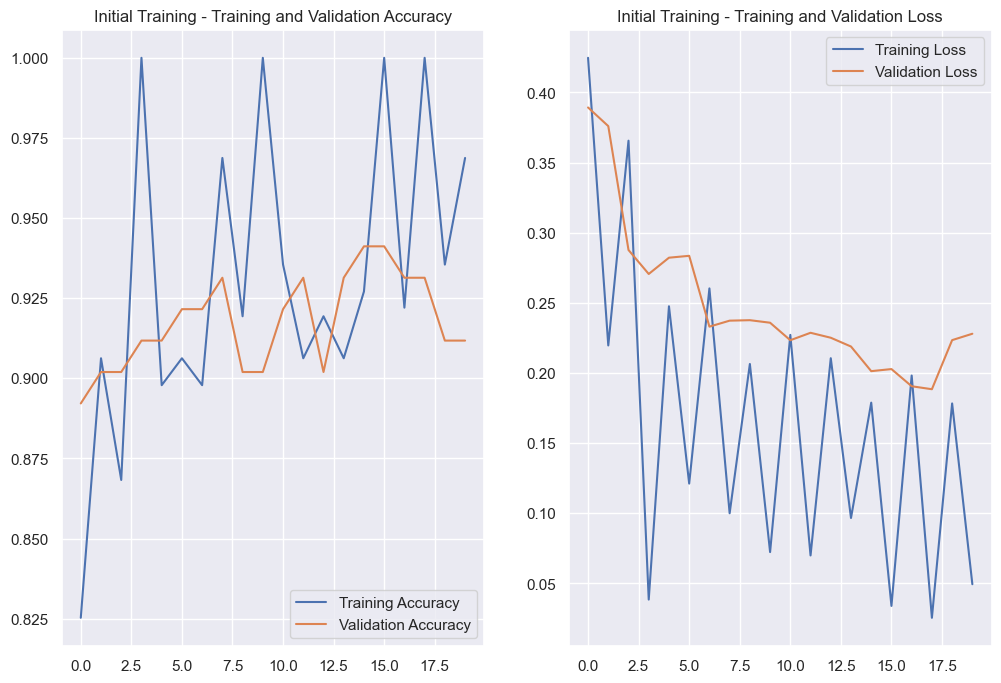

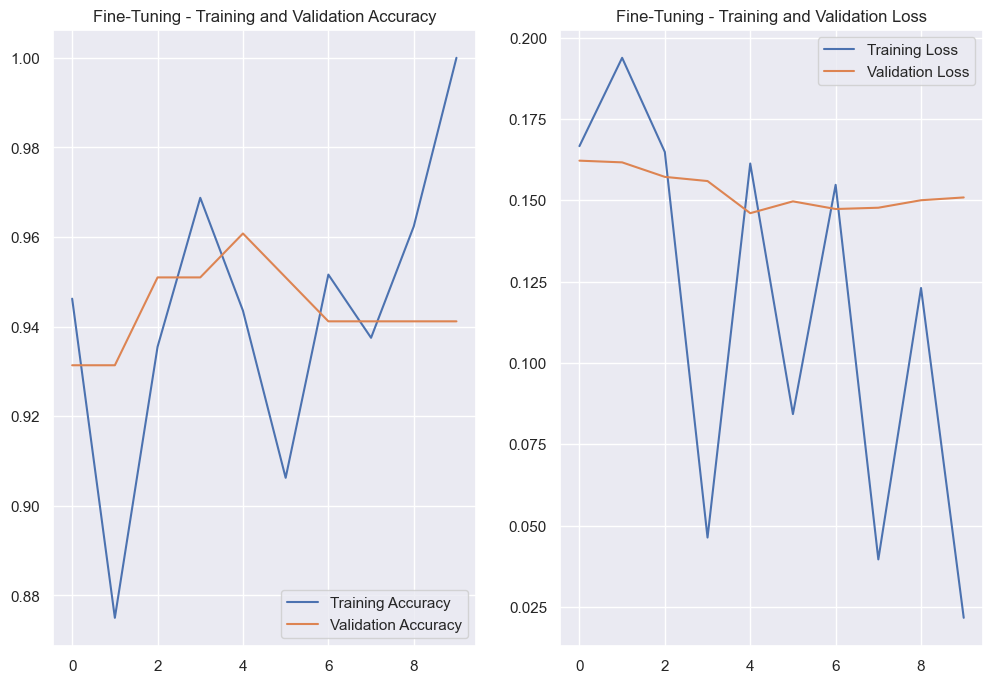

In [20]:
# Plot the training and validation loss and accuracy
def plot_history(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Training and Validation Loss')
    plt.show()

plot_history(history, "Initial Training")
plot_history(history_fine, "Fine-Tuning")
